In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pretty_midi

     |████████████████████████████████| 5.6 MB 4.4 MB/s 
     |████████████████████████████████| 51 kB 7.9 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591953 sha256=eab2cc93d42b2820bde73d6594abefb939f6d591907a20975176246743864a99
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [ ]:
import os
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
import pretty_midi as pm
from PIL import Image
import matplotlib.pyplot as plt

import time
import logging
import pathlib
from tqdm.autonotebook import tqdm
import pandas as pd

from IPython import display

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


In [ ]:
tf.version.VERSION

'2.6.0'

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [ ]:
path = '/content/drive/MyDrive/maestro-v3.0.0-midi/maestro-v3.0.0/2018'

os.chdir(path)
midi_paths = []
for fn in os.listdir():
  midi_paths.append(path+'/'+fn)

In [ ]:
new_dir = '/content/drive/MyDrive/maestro_midi_images/'

In [ ]:
FS = 10
min_note = 21
max_note = 101
img_dims = max_note - min_note

img_dims

80

In [ ]:
def midi2proll(filename):
  midi_pretty_format = pm.PrettyMIDI(filename)
  midi_piano = midi_pretty_format.instruments[0]
  midi_piano_roll = midi_piano.get_piano_roll(fs=FS)
  return midi_piano_roll[:80] # returns piano roll in format (128 notes, time)

def proll2img(proll, show=False):
  im = Image.fromarray(np.uint8(proll))
  if show:
    plt.imshow(np.asarray(im), aspect='auto', cmap='gray')
  return im


def proll2notelist(proll):
  pnotelist = []
  for t, tarr in enumerate(np.transpose(proll)):
    pnotelist.append([])
    for n, val in enumerate(tarr):
      if(val > 0):
        pnotelist[t].append(str(n))          
  return pnotelist

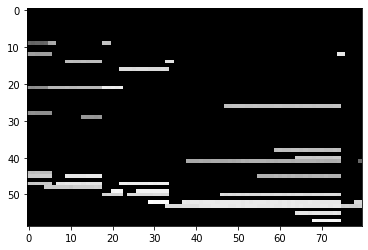

In [ ]:
def reorganize(proll):
  proll = proll[min_note:max_note]
  chops = np.asarray(np.arange(img_dims, len(proll[0]), img_dims))
  proll_chunks = np.split(proll, chops, axis=1)
  return proll_chunks[:-1]

def reorganize_all(filepaths):
  all_proll_chunks = []
  for fp in filepaths:
    all_proll_chunks.append(reorganize(midi2proll(fp)))
  all_proll_chunks = np.concatenate(all_proll_chunks, axis=0)
  return all_proll_chunks

proll = midi2proll(midi_paths[7])
proll_chunks = reorganize(proll)
proll_chunks += tf.random.normal(tf.shape(proll_chunks), stddev=0.2)
img = proll2img(proll_chunks[5], show=True)

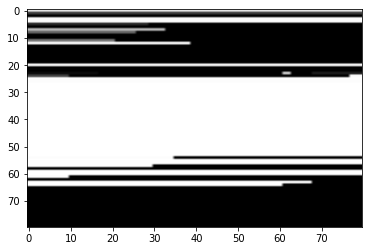

In [ ]:
proll = midi2proll('/content/drive/MyDrive/maestro_midi_images/44/4.mid')
img = proll2img(proll, show=True)

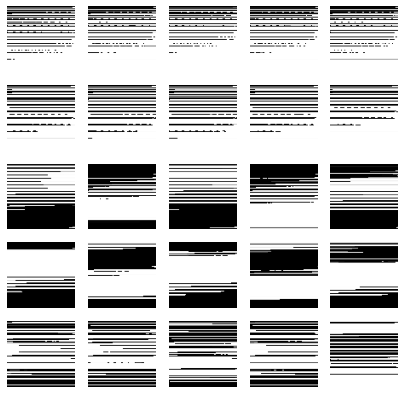

In [ ]:
f, axs = plt.subplots(5,5,figsize=(7,7))

start = len(os.listdir('/content/drive/MyDrive/maestro_midi_images/')) - 5

# bottom is the newest

for r, arr in enumerate(axs):
  for c, _ in enumerate(arr):
    proll = midi2proll(f'/content/drive/MyDrive/maestro_midi_images/{start + r}/{c}.mid')
    img = proll2img(proll)
    axs[r][c].imshow(np.asarray(img), aspect='auto', cmap='gray')
    axs[r][c].axis('off')

In [ ]:
def transform_pnotelist(pnotelist):
  transformed_pnotelist = []
  for notes in pnotelist:
    transformed_pnotelist.append(','.join(notes))
  return np.asarray(transformed_pnotelist)

def chop(arr, chop_size):
  chops = np.asarray(np.arange(chop_size, len(arr), chop_size))
  chunks = np.split(arr, chops, axis=0)
  return chunks[:-1]

def get_all_sequences(filepaths, chop_size=101):
  all_seq = []
  for fp in filepaths:
    chunks = chop(transform_pnotelist(proll2notelist(midi2proll(fp))), chop_size)
    all_seq.extend(chunks)
  all_seq = np.asarray(all_seq)
  return all_seq

def pad_array(arr, target_length):
  if target_length < np.shape(arr)[0]:
    return arr[:target_length]
  padding = np.full((target_length - np.shape(arr)[0],), '')
  return np.concatenate([arr, padding])

In [ ]:
all_seq = get_all_sequences(midi_paths[:32])
musical_corpus = np.concatenate(all_seq)

In [ ]:
print(len(all_seq))
all_seq

2959


array([['', '', '', ..., '57,66', '57,66', '57,66,69'],
       ['57,66,69', '57,66,69', '57,66,69', ..., '62,66,69', '62,78',
        '62,66,78'],
       ['62,78', '62,69,78', '62,69,78', ..., '', '50', '50'],
       ...,
       ['39,51,72,79', '39,51,60,63,72,79', '39,51,60,63,72,79', ...,
        '44,51,55,74,75', '44,51,55,74,75', ''],
       ['44,79', '', '', ..., '51', '60,63', '51,60,63'],
       ['51,56,60,63', '51,56,59,60,62,63,65', '51,56,59,60,62,63,65',
        ..., '32,39,44,51,56,60,68,70,72', '32,39,44,51,56,60,68,70,72',
        '32,39,44,51,56,60,68,70,72']], dtype='<U122')

In [ ]:
vocab_size = np.shape(np.unique(musical_corpus))[0]
vocab_size

44062

In [ ]:
vectorize_layer = layers.TextVectorization(standardize=None, split=None)
vectorize_layer.adapt(musical_corpus)

In [ ]:
all_seq_vectorized = vectorize_layer(all_seq)

In [ ]:
def data_target_split(all_seq):
  return all_seq[:, :-1], all_seq[:, 1:]

In [ ]:
train_data, train_target = data_target_split(all_seq_vectorized)

In [ ]:
TOTAL_SIZE = np.shape(train_data)[0]
BATCH_SIZE = 32
N_TRAIN_BATCHES = int(TOTAL_SIZE/BATCH_SIZE)
N_TEST_BATCHES = N_TRAIN_BATCHES

In [ ]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_data, train_target))
    .cache()
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = train_dataset

# Model

In [ ]:
padding_value = -1

In [ ]:
def get_angles(pos, i, e_dim):
  angles = pos / (np.power(10000, (2 * (i//2) / np.float(e_dim))))
  return angles

def positional_encoding(position, e_dim):
  angles = get_angles(np.arange(position)[:, np.newaxis],
                      np.arange(e_dim)[np.newaxis, :],
                      e_dim)
  angles[:, 0::2] = np.sin(angles[:, 0::2])
  angles[:, 1::2] = np.cos(angles[:, 1::2])

  pos_encoding = angles[np.newaxis, ...]
  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, padding_value), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [ ]:
def scaled_dot_product_attention(q, v, k, mask):
  qk = tf.matmul(q, k, transpose_b=True)
  
  scale_factor = tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))
  scaled_logits = qk / scale_factor
  
  if mask is not None:
    scaled_logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(scaled_logits, axis=-1)
  output = tf.matmul(attention_weights, v)

  return output, attention_weights

class MultiHeadAttention(layers.Layer):
  def __init__(self, e_dim, num_heads, **kwargs):
    super(MultiHeadAttention, self).__init__(**kwargs)
    self.num_heads = num_heads
    self.e_dim = e_dim # dimension of the embeddings

    # input dims  (batch_size, sequence_len, embed_dim)

    assert e_dim % num_heads == 0

    self.depth = e_dim // num_heads

    self.wq = layers.Dense(e_dim)
    self.wv = layers.Dense(e_dim)
    self.wk = layers.Dense(e_dim)

    self.dense = layers.Dense(e_dim)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    return x

  def call(self, q, v, k, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q) # (batch_size, sequence_len, embed_dim)
    v = self.wv(v) # (batch_size, sequence_len, embed_dim)
    k = self.wk(k) # (batch_size, sequence_len, embed_dim)
    
    q = self.split_heads(q, batch_size) # (batch_size, num_heads, sequence_len_q, depth)
    v = self.split_heads(v, batch_size) # (batch_size, num_heads, sequence_len_v, depth)
    k = self.split_heads(k, batch_size) # (batch_size, num_heads, sequence_len_k, depth)

    # att.    (batch_size, num_heads, sequence_len_q, depth)
    # att. w  (batch_size, num_heads, sequence_len_q, sequence_len_k)
    attention, attention_weights = scaled_dot_product_attention(q, v, k, mask)

    attention = tf.transpose(attention, perm=[0, 2, 1, 3]) # (batch_size, sequence_len_q, num_heads, depth)
    concat_attention = tf.reshape(attention, (batch_size, -1, self.e_dim)) # (batch_size, sequence_len_q, embed_dim)
    
    output = self.dense(concat_attention) # (batch_size, sequence_len_q, embed_dim)

    return output, attention_weights

def pwffn(e_dim, dff):
  return models.Sequential(
      [
       layers.Dense(dff, activation='relu'), # (batch_size, seq_len, dff)
       layers.Dense(e_dim) # (batch_size, seq_len, embed_dim)
      ]
  )

In [ ]:
class EncoderLayer(layers.Layer):
  def __init__(self, e_dim, num_heads, dff, dropout_rate=0.1):
    super(EncoderLayer, self).__init__()
    
    self.mha = MultiHeadAttention(e_dim, num_heads)
    self.ffn = pwffn(e_dim, dff)

    self.norm1 = layers.LayerNormalization(epsilon=1e-6)
    self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = layers.Dropout(rate=dropout_rate)
    self.dropout2 = layers.Dropout(rate=dropout_rate)
  
  def call(self, x, training, mask):

    o1, _ = self.mha(x, x, x, mask)
    o1 = self.dropout1(o1, training=training)
    o1 = self.norm1(x + o1)

    o2 = self.ffn(o1)
    o2 = self.dropout2(o2, training=training)
    o2 = self.norm2(o1 + o2)
    return o2

class DecoderLayer(layers.Layer):
  def __init__(self, e_dim, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()
    
    self.mha1 = MultiHeadAttention(e_dim, num_heads)
    self.mha2 = MultiHeadAttention(e_dim, num_heads)
    self.ffn = pwffn(e_dim, dff)

    self.norm1 = layers.LayerNormalization(epsilon=1e-6)
    self.norm2 = layers.LayerNormalization(epsilon=1e-6)
    self.norm3 = layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = layers.Dropout(rate=dropout_rate)
    self.dropout2 = layers.Dropout(rate=dropout_rate)
    self.dropout3 = layers.Dropout(rate=dropout_rate)
  
  def call(self, x, encoder_output, training, look_ahead_mask, padding_mask):
    o1, att_w_block1 = self.mha1(x, x, x, look_ahead_mask)
    o1 = self.dropout1(o1, training=training)
    o1 = self.norm1(x + o1)
    
    o2, att_w_block2 = self.mha2(o1, encoder_output, encoder_output, padding_mask)
    o2 = self.dropout2(o2, training=training)
    o2 = self.norm2(o1 + o2)

    o3 = self.ffn(o2)
    o3 = self.dropout3(o3, training=training)
    o3 = self.norm3(o2 + o3)
    return o3, att_w_block1, att_w_block2

In [ ]:
class Encoder(layers.Layer):
  def __init__(self, num_layers, e_dim, num_heads, dff, input_vocab_size, max_pos_enc, dropout_rate=0.1):
    super(Encoder, self).__init__()

    self.e_dim = e_dim
    self.num_layers = num_layers

    self.embedding = layers.Embedding(input_vocab_size, e_dim)
    self.pos_enc = positional_encoding(max_pos_enc, e_dim)

    self.enc_layers = [EncoderLayer(e_dim, num_heads, dff, dropout_rate) for _ in range(num_layers)]
    self.dropout = layers.Dropout(dropout_rate)

  def call(self, x, training, mask):
    seq_len = tf.shape(x)[1]

    x = self.embedding(x) # (batch_size, input_seq_len, e_dim)
    x *= tf.math.sqrt(tf.cast(self.e_dim, tf.float32))
    x += self.pos_enc[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for el in self.enc_layers:
      x = el(x, training, mask)

    return x # (batch_size, input_seq_len, e_dim)


class Decoder(layers.Layer):
  def __init__(self, num_layers, e_dim, num_heads, dff, target_vocab_size, max_pos_enc, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.e_dim = e_dim
    self.num_layers = num_layers

    self.embedding = layers.Embedding(target_vocab_size, e_dim)
    self.pos_enc = positional_encoding(max_pos_enc, e_dim)

    self.dec_layers = [DecoderLayer(e_dim, num_heads, dff, dropout_rate) for _ in range(num_layers)]
    self.dropout = layers.Dropout(dropout_rate)

  def call(self, x, encoder_output, training, look_ahead_mask, padding_mask):
    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x) # (batch_size, target_seq_len, e_dim)
    x *= tf.math.sqrt(tf.cast(self.e_dim, tf.float32))
    x += self.pos_enc[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i, dl in enumerate(self.dec_layers):
      x, block1, block2 = dl(x, encoder_output, training, look_ahead_mask, padding_mask)
      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    return x, attention_weights # x --> (batch_size, target_seq_len, e_dim)


In [ ]:
class Transformer(models.Model):
  def __init__(self, vectorize_layer, num_layers, e_dim, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, dropout_rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, e_dim, num_heads, dff, input_vocab_size, pe_input, dropout_rate)
    self.decoder = Decoder(num_layers, e_dim, num_heads, dff, target_vocab_size, pe_target, dropout_rate)

    self.final_layer = layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
    enc_out = self.encoder(inp, training, enc_padding_mask)
    dec_out, attn_weights = self.decoder(tar, enc_out, training, look_ahead_mask, dec_padding_mask)
    output = self.final_layer(dec_out)
    return output, attn_weights

## Hyperparams, Optimization, and Loss 

In [ ]:
num_layers = 3
e_dim = 256
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, e_dim, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.e_dim = tf.cast(e_dim, tf.float32)
    self.warmup_steps = warmup_steps
  
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.e_dim) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(e_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  loss = loss_object(real, pred)
  mask = tf.cast(tf.math.logical_not(tf.math.equal(real, padding_value)), dtype=loss.dtype)
  loss *= mask
  return tf.reduce_sum(loss) / tf.reduce_sum(mask)

def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, tf.float32)
  mask = tf.cast(mask, tf.float32)
  return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

# Eval

In [ ]:
def evaluate(start, max_length=100):
  start = tf.convert_to_tensor([sentence])
  start = tokenizers.pt.tokenize(sentence).to_tensor()

  encoder_input = start

  start_token, end_token = [0]
  output = tf.convert_to_tensor([start_token])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
    predictions, attn_weights = transformer(encoder_input, output, False, enc_padding_mask, combined_mask, dec_padding_mask)
    predictions = predictions[:, -1:, :]
    predicted_id = tf.argmax(predictions, axis=-1)
    output = tf.concat([output, predicted_id], axis=-1)
    if predicted_id == end_token:
      break
  
  text = tokenizers.en.detokenize(output)[0]
  tokens = tokenizers.en.lookup(output)[0]

  return text, tokens, attn_weights

## Training

In [ ]:
transformer = Transformer(
    vectorize_layer=vectorize_layer,
    num_layers=num_layers,
    e_dim=e_dim,
    num_heads=num_heads,
    dff = dff,
    input_vocab_size=vocab_size,
    target_vocab_size=vocab_size,
    pe_input=100,
    pe_target=100,
    dropout_rate=dropout_rate
)

In [ ]:
def create_masks(inp, tar):
  enc_padding_mask = create_padding_mask(inp)
  dec_padding_mask = create_padding_mask(inp)

  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [ ]:
@tf.function()
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_weights)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()
  epoch_length = len(train_dataset)
  out = display(progress(0, epoch_length), display_id=True)

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 1 == 0:
      print(f'Epoch {epoch + 1}\tBatch {batch}  \tLoss {train_loss.result():.4f}\tAccuracy {train_accuracy.result():.4f}')
    
    out.update(progress(batch, epoch_length))
  
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1}\tLoss {train_loss.result():.4f}\tAccuracy {train_accuracy.result():.4f}')

  print(f'Time take for 1 epoch: {time.time() - start:.2f} seconds\n')

Epoch 1	Batch 0	Loss 10.6798	Accuracy 0.0014
Epoch 1	Batch 1	Loss 10.6776	Accuracy 0.0007
Epoch 1	Batch 2	Loss 10.6777	Accuracy 0.0007
Epoch 1	Batch 3	Loss 10.6767	Accuracy 0.0010
Epoch 1	Batch 4	Loss 10.6772	Accuracy 0.0008
Epoch 1	Batch 5	Loss 10.6750	Accuracy 0.0010
Epoch 1	Batch 6	Loss 10.6734	Accuracy 0.0010
Epoch 1	Batch 7	Loss 10.6725	Accuracy 0.0010
Epoch 1	Batch 8	Loss 10.6729	Accuracy 0.0008
Epoch 1	Batch 9	Loss 10.6731	Accuracy 0.0009
Epoch 1	Batch 10	Loss 10.6715	Accuracy 0.0013
Epoch 1	Batch 11	Loss 10.6711	Accuracy 0.0012
Epoch 1	Batch 12	Loss 10.6701	Accuracy 0.0014
Epoch 1	Batch 13	Loss 10.6695	Accuracy 0.0014
Epoch 1	Batch 14	Loss 10.6695	Accuracy 0.0015
Epoch 1	Batch 15	Loss 10.6695	Accuracy 0.0016
Epoch 1	Batch 16	Loss 10.6697	Accuracy 0.0018
Epoch 1	Batch 17	Loss 10.6692	Accuracy 0.0019
Epoch 1	Batch 18	Loss 10.6693	Accuracy 0.0018
Epoch 1	Batch 19	Loss 10.6682	Accuracy 0.0019
Epoch 1	Batch 20	Loss 10.6680	Accuracy 0.0019
Epoch 1	Batch 21	Loss 10.6675	Accuracy 0.002

InvalidArgumentError: ignored